In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates
import statsmodels.api as sm
from datetime import datetime
pd.options.plotting.backend = "plotly"

### Weekday frequency analysis

In [137]:
sales1 = pd.read_pickle("../Data/total_sales_09-10_cleaned.pkl")
sales1 = sales1[sales1['date'] >= '2010-01-01']

In [138]:
sales1.head(10)

,date,weekday,hour,total_amount
206,2010-01-04,Monday,9,45.00
207,2010-01-04,Monday,10,554.58
208,2010-01-04,Monday,11,230.90
209,2010-01-04,Monday,12,2705.35
210,2010-01-04,Monday,13,7228.35
211,2010-01-04,Monday,14,635.90
212,2010-01-04,Monday,15,1237.17
213,2010-01-04,Monday,16,543.81
214,2010-01-04,Monday,17,269.48
215,2010-01-05,Tuesday,8,316.70


### Purchase Frequency

In [139]:
sales1_byWeekday = sales1.groupby('weekday', as_index = False).count()
sales1_byWeekday = sales1_byWeekday.drop(columns = ['date', 'hour'])
sales1_byWeekday = sales1_byWeekday.rename(columns = {'total_amount':'purchase_frequency'})
sales1_byWeekday.head(10)

,weekday,purchase_frequency
0,Friday,429
1,Monday,431
2,Sunday,322
3,Thursday,583
4,Tuesday,483
5,Wednesday,456


In [140]:
fig = px.histogram(sales1_byWeekday, x="weekday", 
    y='purchase_frequency', 
    color = 'weekday', 
    text_auto=True,
    labels={'purchase_frequency': 'Purchase Frequency'},
    title="Purchase Frequency by Weekday")
fig.update_xaxes(categoryorder='array', categoryarray= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.update_layout(bargap=0.2)
fig.show()

### Sales amount barplot

In [141]:
sales1_amount = sales1.drop(columns=['date', 'hour'])
sales1_amount.head(10)

,weekday,total_amount
206,Monday,45.00
207,Monday,554.58
208,Monday,230.90
209,Monday,2705.35
210,Monday,7228.35
211,Monday,635.90
212,Monday,1237.17
213,Monday,543.81
214,Monday,269.48
215,Tuesday,316.70


In [142]:
fig = px.box(sales1, x='total_amount', y='weekday', 
    color = 'weekday',
    labels={'total_amount': 'Total Amount'},
    title="Total Amount by Weekday")

fig.update_xaxes(
    range=[0,15000],  # sets the range of xaxis
)
fig.show()


### Quarter Analysis

In [143]:
def toQuarter(temp_date):
    month = str(temp_date)[5:7]
    return 'Q'+ str((int(month)-1)//3 + 1)

In [144]:
sales1['quarter'] = [toQuarter(ele) for ele in sales1['date']]
sales1_byQuarter = sales1.groupby('quarter', as_index = False).sum()
sales1_byQuarter = sales1_byQuarter.drop(columns = ['hour'])
sales1_byQuarter.head(10)

,quarter,total_amount
0,Q1,1417438.189
1,Q2,1548266.721
2,Q3,1694313.781
3,Q4,2141522.372


In [145]:
fig = px.histogram(sales1_byQuarter, x="quarter", 
    y='total_amount', 
    color = 'quarter', 
    text_auto=True,
    labels={'total_amount': 'Total Amount'})
fig.update_layout(bargap=0.2)
fig.show()

In [146]:
sales1_byQuarter = sales1.groupby('quarter', as_index = False).count()
sales1_byQuarter = sales1_byQuarter.drop(columns = ['date', 'hour', 'weekday'])
sales1_byQuarter = sales1_byQuarter.rename(columns = {'total_amount':'purchase_frequency'})
sales1_byQuarter.head(10)

,quarter,purchase_frequency
0,Q1,690
1,Q2,688
2,Q3,730
3,Q4,596


In [147]:
fig = px.histogram(sales1_byQuarter, x="quarter", 
    y='purchase_frequency', 
    color = 'quarter', 
    text_auto=True,
    labels={'purchase_frequency': 'Purchase Frequency'})
fig.update_layout(bargap=0.2)
fig.show()

In [148]:
fig = px.box(sales1, x='total_amount', y='quarter', 
    color = 'quarter')

fig.update_xaxes(
    range=[0,15000],  # sets the range of xaxis
)
fig.show()

## Pre-modeling

In [74]:
sales1 = pd.read_pickle("../Data/total_sales_09-10_cleaned.pkl")
sales1 = sales1[sales1['date'] >= '2010-01-01']
sales1.head(5)

,date,weekday,hour,total_amount
206,2010-01-04,Monday,9,45.00
207,2010-01-04,Monday,10,554.58
208,2010-01-04,Monday,11,230.90
209,2010-01-04,Monday,12,2705.35
210,2010-01-04,Monday,13,7228.35


In [75]:
def convert_hour(ele):
    if len(str(ele)) < 2:
        return '0' + str(ele)
    else:
        return str(ele)

In [76]:
sales1['date_h'] = sales1['date'].astype(str) + '-' + sales1['hour'].astype(str)
sales1['hour'] = [convert_hour(ele) for ele in sales1['hour']]
sales1['date_h'] = [datetime.strptime(ele, '%Y-%m-%d-%H') for ele in sales1['date_h']]
sales1.head(5)

,date,weekday,hour,total_amount,date_h
206,2010-01-04,Monday,09,45.00,2010-01-04 09:00:00
207,2010-01-04,Monday,10,554.58,2010-01-04 10:00:00
208,2010-01-04,Monday,11,230.90,2010-01-04 11:00:00
209,2010-01-04,Monday,12,2705.35,2010-01-04 12:00:00
210,2010-01-04,Monday,13,7228.35,2010-01-04 13:00:00


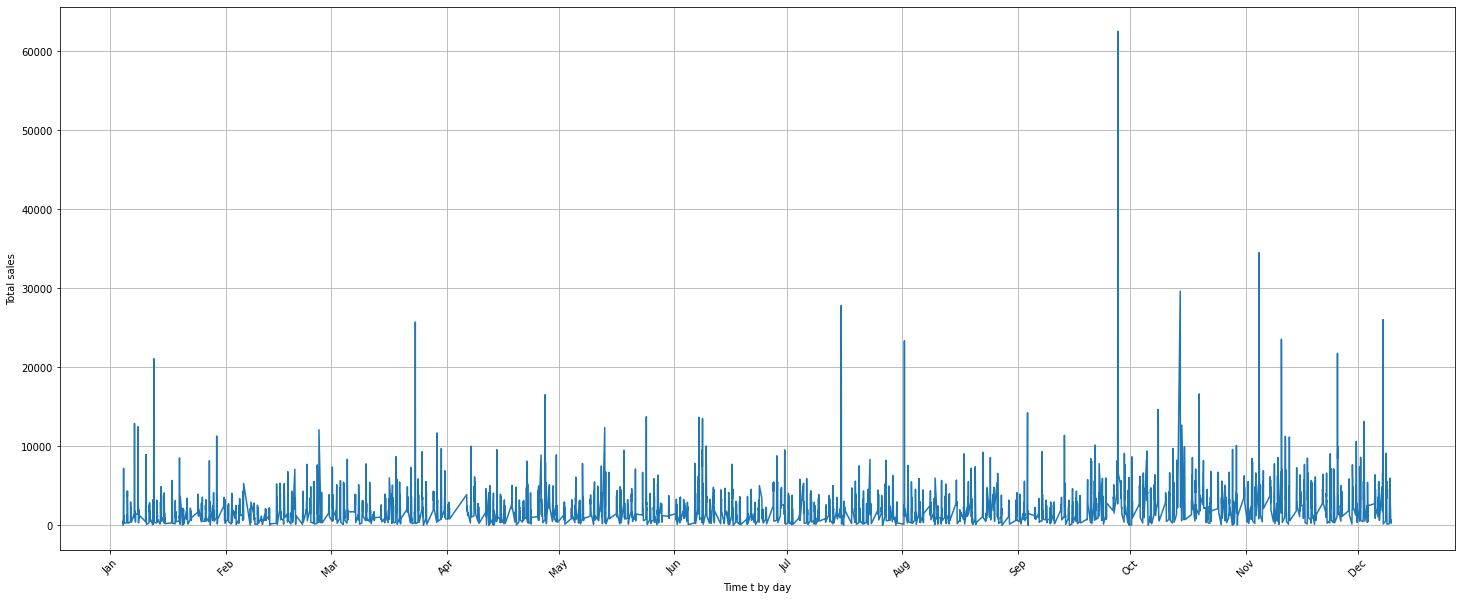

In [77]:
plt.figure(figsize=(25,10))

plt.xticks(rotation=45)
plt.plot(sales1['date_h'], sales1['total_amount'])
plt.ylabel('Total sales')
plt.xlabel('Time t by day')
plt.grid(True)

locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)
plt.show()

<Figure size 1440x720 with 0 Axes>

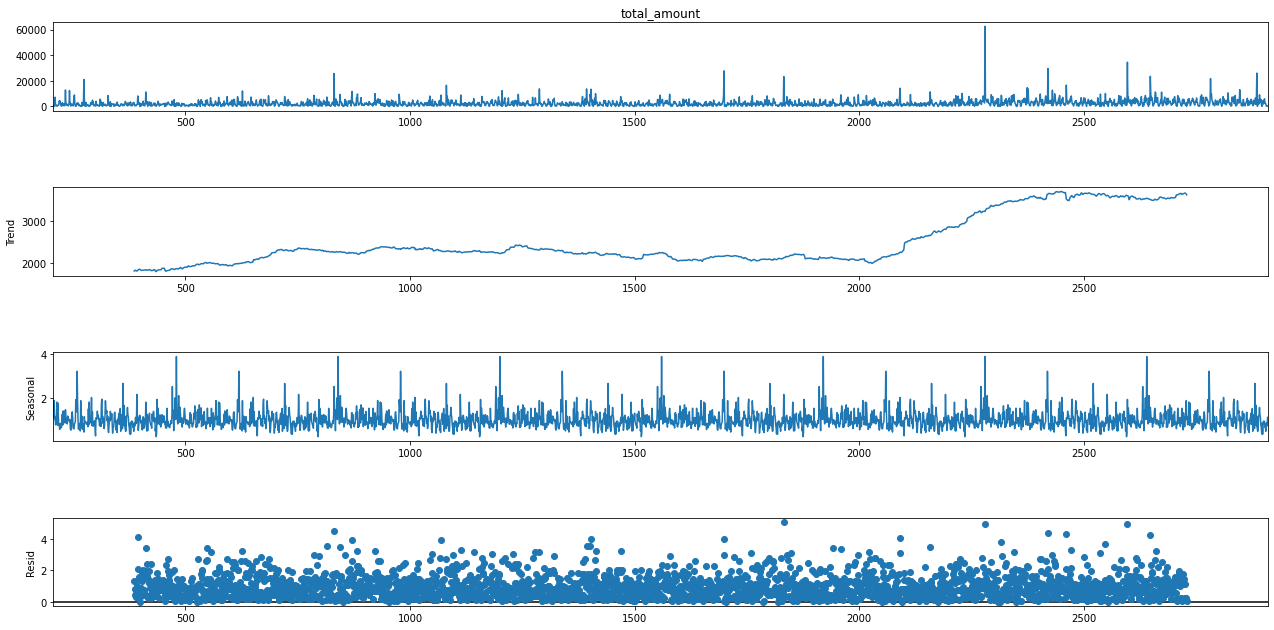

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,10))
decomposition = seasonal_decompose(sales1['total_amount'], 
                                   model='multiplicative', 
                                   period=360)
fig = decomposition.plot()
fig.set_size_inches((20,10))
plt.show()

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### From the acf and pacf graph, we are pretty sure that at least an ARMA should be used later but the best choice of the combination of p and q is not obvious.

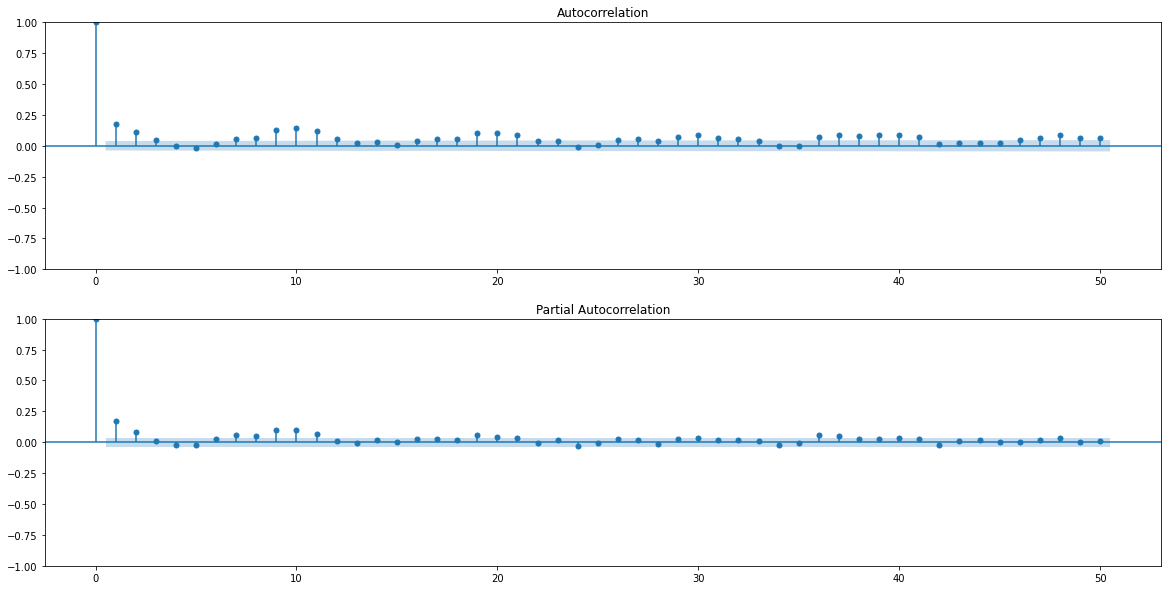

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
plot_acf(sales1['total_amount'], lags=50, ax = ax[0])
plot_pacf(sales1['total_amount'], lags=50, ax = ax[1])
plt.show()

In [80]:
sales1 = sales1.drop(columns=['weekday', 'hour', 'date'])
sales1.set_index('date_h', inplace=True)
sales1.sort_index(inplace=True) 
sales1_train = sales1[:int(0.8*sales1.shape[0])]
sales1_test = sales1[int(0.8*sales1.shape[0]):]
print('Shape of training set:', sales1_train.shape)
print('Shape of testing set:', sales1_test.shape)

Shape of training set: (2163, 1)
Shape of testing set: (541, 1)


In [66]:
model = sm.tsa.SARIMAX(sales1['total_amount'], order=(1,1,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:           total_amount   No. Observations:                 2704
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -25178.313
Date:                Mon, 13 Feb 2023   AIC                          50362.625
Time:                        14:10:58   BIC                          50380.331
Sample:                             0   HQIC                         50369.028
                               - 2704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1281      0.015      8.577      0.000       0.099       0.157
ma.L1         -0.9900      0.003   -364.683      0.000      -0.995      -0.985
sigma2      7.209e+06   3.19e+04    226.084      0.0

In [81]:
import itertools as it
import warnings
warnings.filterwarnings('ignore')

p_min = 0
d_min = 0
q_min = 0

p_max = 5
d_max = 3
q_max = 10

col = ['AR', 'MA', "Diff", 'AIC', 'BIC']
result_frame = pd.DataFrame(columns = col)

for p, d, q in it.product(range(p_min, p_max+1), range(d_min, d_max+1), range(q_min, q_max+1)):
    print('AR: ', p, ' DIFF: ', d, ' MA: ', q)
    if p==0 and d==0 and q==0:
        new_df = pd.DataFrame([[0,0,0,np.nan,np.nan]], columns=col)
        result_frame = pd.concat([new_df, result_frame], ignore_index=True)
        continue
    try:
        model = sm.tsa.SARIMAX(sales1_train['total_amount'], order=(p,d,q))
        results = model.fit()
        new_df = pd.DataFrame([[p,d,q,results.aic,results.bic]], columns = col)
        result_frame = pd.concat([new_df, result_frame], ignore_index=True)
        
    except:
        continue
        

AR:  0  DIFF:  0  MA:  0
AR:  0  DIFF:  0  MA:  1
AR:  0  DIFF:  0  MA:  2
AR:  0  DIFF:  0  MA:  3
AR:  0  DIFF:  0  MA:  4
AR:  0  DIFF:  0  MA:  5
AR:  0  DIFF:  0  MA:  6
AR:  0  DIFF:  0  MA:  7
AR:  0  DIFF:  0  MA:  8
AR:  0  DIFF:  0  MA:  9
AR:  0  DIFF:  0  MA:  10
AR:  0  DIFF:  1  MA:  0
AR:  0  DIFF:  1  MA:  1
AR:  0  DIFF:  1  MA:  2
AR:  0  DIFF:  1  MA:  3
AR:  0  DIFF:  1  MA:  4
AR:  0  DIFF:  1  MA:  5
AR:  0  DIFF:  1  MA:  6
AR:  0  DIFF:  1  MA:  7
AR:  0  DIFF:  1  MA:  8
AR:  0  DIFF:  1  MA:  9
AR:  0  DIFF:  1  MA:  10
AR:  0  DIFF:  2  MA:  0
AR:  0  DIFF:  2  MA:  1
AR:  0  DIFF:  2  MA:  2
AR:  0  DIFF:  2  MA:  3
AR:  0  DIFF:  2  MA:  4
AR:  0  DIFF:  2  MA:  5
AR:  0  DIFF:  2  MA:  6
AR:  0  DIFF:  2  MA:  7
AR:  0  DIFF:  2  MA:  8
AR:  0  DIFF:  2  MA:  9
AR:  0  DIFF:  2  MA:  10
AR:  0  DIFF:  3  MA:  0
AR:  0  DIFF:  3  MA:  1
AR:  0  DIFF:  3  MA:  2
AR:  0  DIFF:  3  MA:  3
AR:  0  DIFF:  3  MA:  4
AR:  0  DIFF:  3  MA:  5
AR:  0  DIFF:  3  MA: 

In [82]:
result_frame.head(10)

,AR,MA,Diff,AIC,BIC
0,5,3,10,40087.295873,40178.141689
1,5,3,8,40139.893502,40219.383591
2,5,3,7,40186.018407,40259.830633
3,5,3,6,40675.190549,40743.324911
4,5,3,5,40572.864558,40635.321057
5,5,3,4,40563.684023,40620.462658
6,5,3,3,40638.149763,40689.250534
7,5,3,2,40764.182139,40809.605047
8,5,3,1,41067.095833,41106.840877
9,5,3,0,42134.800902,42168.868083


In [83]:
result_frame.to_csv('byday_result.csv')

In [84]:
result_frame.describe()

,AR,MA,Diff,AIC,BIC
count,261,261,261,260.000000,260.000000
unique,6,4,11,260.000000,260.000000
top,4,2,10,40087.295873,40178.141689
freq,44,66,24,1.000000,1.000000


In [85]:
result_frame['AIC'] = pd.to_numeric(result_frame['AIC'])
min_aic = result_frame.loc[result_frame['AIC'].idxmin()]
result_frame['BIC'] = pd.to_numeric(result_frame['BIC'])
min_bic = result_frame.loc[result_frame['BIC'].idxmin()]
print('Minimum AIC: \n', min_aic)
print('Minimum BIC: \n', min_bic)

Minimum AIC: 
 AR                 0
MA                 3
Diff               3
AIC     29910.572631
BIC     29933.284085
Name: 224, dtype: object
Minimum BIC: 
 AR                 0
MA                 3
Diff               3
AIC     29910.572631
BIC     29933.284085
Name: 224, dtype: object


In [112]:
tra = sales1_train['total_amount'].dropna()
tes = sales1_test['total_amount'].dropna()

In [106]:
sales1_train_exog = sales1_train.drop(['total_amount'],axis=1)
sales1_test_exog = sales1_test.drop(['total_amount'],axis=1)


In [133]:
opt_model = sm.tsa.SARIMAX(sales1['total_amount'], order=(0,3,3))
opt_model_fit = opt_model.fit()
sales1_predict = opt_model_fit.predict(start = '2010-10-07 16:00:00', end = '2010-12-09 20:00:00', exog = sales1_test_exog)


In [159]:
opt_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           total_amount   No. Observations:                 2704
Model:               SARIMAX(0, 3, 3)   Log Likelihood              -25712.011
Date:                Mon, 13 Feb 2023   AIC                          51432.021
Time:                        15:44:13   BIC                          51455.627
Sample:                             0   HQIC                         51440.557
                               - 2704                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.9292      0.019   -153.594      0.000      -2.967      -2.892
ma.L2          2.8610      0.038     75.083      0.000       2.786       2.936
ma.L3         -0.9317      0.019    -48.846      0.000      -0.969      -0.894
sigma2      1.994e+07    4.3e-09   4.64e+15      0.000    1.99e+07    1.99e+07
===================================================================================
Ljung-Box (L1) (Q):                  36.51   Jarque-Bera (JB):           1015768.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.73   Skew:                             6.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        97.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.67e+29. Standard errors may be unstable.
"""

In [135]:
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(tes, sales1_predict))

MAE:  2214.456725205741
